# CS M148 Project 2 - Binary Classification Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a **patient is suffering from heart disease** based on a host of potential medical factors.

**DEFINITIONS**

**Binary Classification:** In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

**Supervised Learning:** This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
- **age:** Age in years
- **sex:** (1 = male; 0 = female)
- **cp:** Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)
- **trestbps:** Resting blood pressure (in mm Hg on admission to the hospital)
- **cholserum:** Cholestoral in mg/dl
- **fbs** Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- **restecg:** Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))
- **thalach:** Maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeakST:** Depression induced by exercise relative to rest
- **slope:** The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)
- **ca:** Number of major vessels (0-4) colored by flourosopy
- **thal:** 1 = normal; 2 = fixed defect; 3 = reversable defect
- **sick:** Indicates the presence of Heart disease (True = Disease; False = No disease)

`sick` is the label that you will be predicting.

## Loading Essentials and Helper Functions 

In [99]:
# Here are a set of libraries we imported to complete this assignment. 
# Feel free to use these or equivalent libraries for your implementation
# If you can run this cell without any errors, you're ready to go.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 

import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from matplotlib import pyplot

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import os
import itertools
import random 

%matplotlib inline

random.seed(148) 

In [100]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [101]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Load the Data and Analyze

Let's load our dataset so we can work with it (correct the path if your notebook is in a different directory than the .csv file).

In [102]:
heart0 = pd.read_csv('heartdisease.csv')

### Question 1.1 

Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method, the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [103]:
# Your code here
# You may use separate cells if you'd like (one for `head`, one for `describe`, etc.)

# show first few rows of the data
heart0.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,False
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,False
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,False
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,False
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,False


In [104]:
# show data types of each column
heart0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
sick        303 non-null bool
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


In [105]:
# show stats of numerical features
heart0.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


### Question 1.2
Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

[Use this area to describe any fields you believe will be problemmatic and why] E.g., All the columns in our dataframe are numeric (either int or float), however our target variable 'sick' is a boolean and may need to be modified.

I think the `cp`, `restecg`, `slope`, and `thal` features will be problematic, and all for the same reason: they are encoded categorically, but the things that each number respresents don't follow a reasonable linear pattern. For example, the `thal` column encodes 1 = normal; 2 = fixed defect; 3 = reversable defect. It doesn't seem right to say that a reversable defect is "more" than a fixed defect.

To fix each of these, I would most likely one-hot encode them, or in the case of the `thal` column, I might swap the "fixed defect" and "reversable defect" encodings, since that might cause it to be a reasonable progression through three states.

Also, it may be needed to change the `sick` column from TRUE/FALSE to 1/0.

### Question 1.3
Determine if we're dealing with any null values. If so, report which columns.

In [106]:
# sum of isnull results will tell us total amount of nulls in each column
heart0.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
sick        0
dtype: int64

...looks like there are no nulls in the entire dataframe.

In [107]:
# also: check that all categorical variables only include the levels they have a category specified for
heart0[['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'sick']].apply(pd.Series.value_counts)

,sex,cp,fbs,restecg,exang,slope,ca,thal,sick
0,96.0,143.0,258.0,147.0,204.0,21.0,175,2.0,165.0
1,207.0,50.0,45.0,152.0,99.0,140.0,65,18.0,138.0
2,NaN,87.0,NaN,4.0,NaN,142.0,38,166.0,NaN
3,NaN,23.0,NaN,NaN,NaN,NaN,20,117.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN


Here, we notice that two samples have a value of 0 for `thal`, which is invalid... we'll need to handle those rows somehow

### Question 1.4
Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean `sick` variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original `sick` datafield from the dataframe.

In [108]:
# convert boolean sick to int sick
heart = heart0.copy()
heart['sick'] = list(map(int, heart['sick']))
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,sick
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,0
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,0
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,0
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,0
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,0


In [109]:
# one hot encode the columns I think shouldn't be categorical

# keep track of numerical and categorical features (categorical features that work as numerical ones belong in 'num')
num = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca', 'sick']
cat = list(set(heart.columns) - set(num))
print(num)
print(cat)

# run the one hot encoder
ohe = OneHotEncoder(categories = 'auto')
cat_onehot = ohe.fit_transform(heart[cat])

# get new onehot-encoded variables
cat_onehot = pd.DataFrame(cat_onehot.toarray(), columns = ohe.get_feature_names(cat))
cat_onehot.head()

['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca', 'sick']
['slope', 'restecg', 'thal', 'cp']


,slope_0,slope_1,slope_2,restecg_0,restecg_1,restecg_2,thal_0,thal_1,thal_2,thal_3,cp_0,cp_1,cp_2,cp_3
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [110]:
# update the categorical features with OHE version in the original data
heart = pd.concat([heart[num], cat_onehot], axis = 1)
# remove thal_0 column, we don't know what that means
heart = heart.drop('thal_0', axis = 1)
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 23 columns):
age          303 non-null int64
sex          303 non-null int64
trestbps     303 non-null int64
chol         303 non-null int64
fbs          303 non-null int64
thalach      303 non-null int64
exang        303 non-null int64
oldpeak      303 non-null float64
ca           303 non-null int64
sick         303 non-null int64
slope_0      303 non-null float64
slope_1      303 non-null float64
slope_2      303 non-null float64
restecg_0    303 non-null float64
restecg_1    303 non-null float64
restecg_2    303 non-null float64
thal_1       303 non-null float64
thal_2       303 non-null float64
thal_3       303 non-null float64
cp_0         303 non-null float64
cp_1         303 non-null float64
cp_2         303 non-null float64
cp_3         303 non-null float64
dtypes: float64(14), int64(9)
memory usage: 54.6 KB


### Question 1.5
Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to get a feel of how each variable performs (for example, is it a binary, or limited selection, or does it follow a gradient)? 

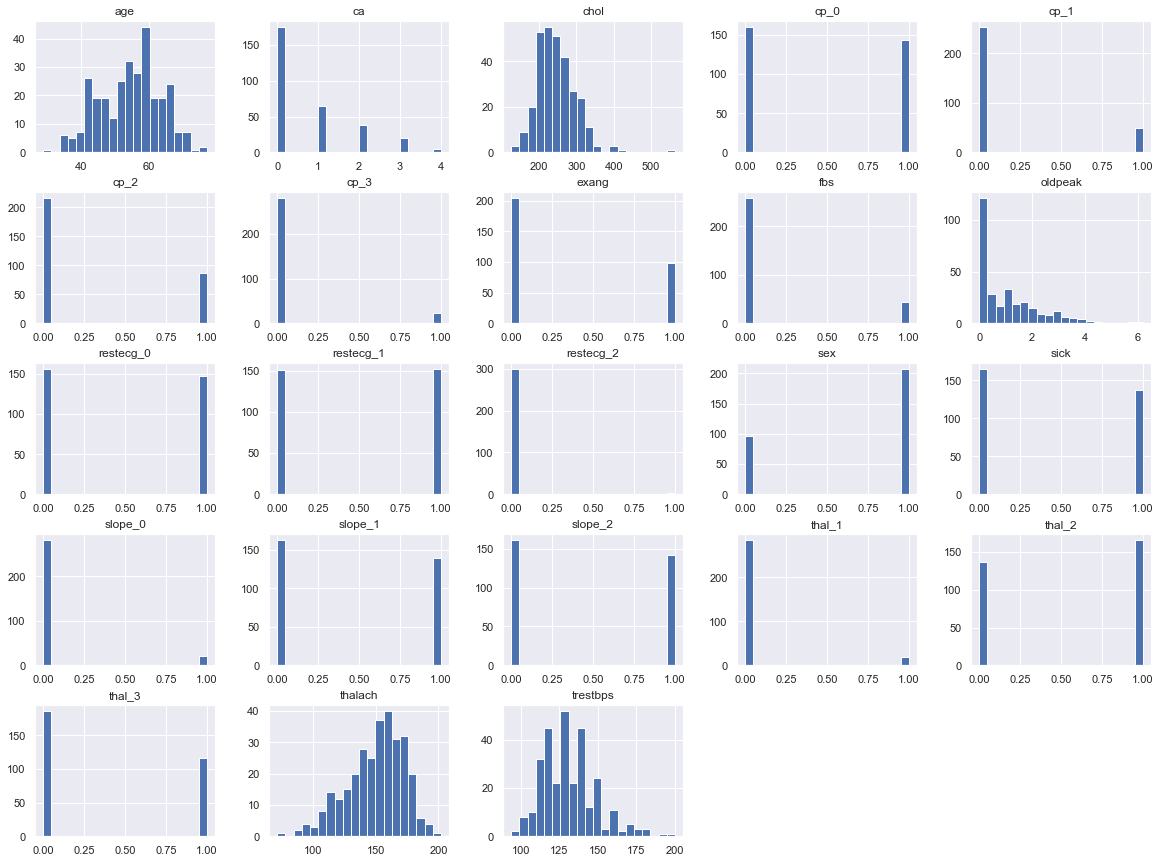

In [111]:
heart.hist(bins = 20, figsize=(20,15))
plt.show()

### Question 1.6
We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results.

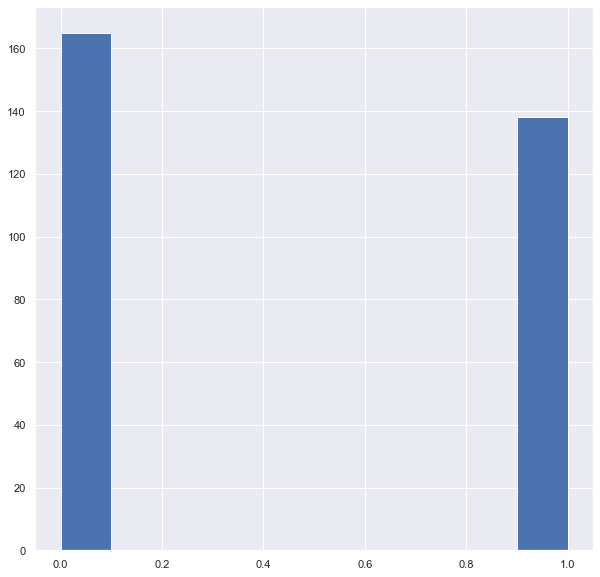

In [112]:
# plot distribution of sick variable
heart['sick'].hist(bins = 10, figsize = (10,10))

In [113]:
# count number of cases and controls
cases = sum(heart['sick'])
controls = len(heart['sick']) - cases
print("cases: " + str(cases))
print("controls: " + str(controls))
print("Percent cases = " + str(cases/len(heart['sick'])))

cases: 138
controls: 165
Percent cases = 0.45544554455445546


[Include description of findings here] E.g., As we can see, our sample contains xxx healthy individuals and yyy sick individuals, which reflects a [your conclusion here].

The sample has 165 healthy and 138 sick individuals, meaning 45% of the sample is sick. This is very close to an ideally balanced sample (50/50). I don't think we will run into any issues with case/control balance in this analysis.

### Question 1.7 
Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

[You answer here] E.g., artificially inflating numbers to balance a dataset may result in xxx. Concurrently showing statistically uncommon events as likely may result in yyy.

Ways to artificially balance a dataset:
* Downsample the majority group - the downside of this method is that your sample size will decrease, thus increasing the amount of bias your sample will contain relative to the full population and decreasing power.
* Augment/synthesize more members of the minority group - the downside here is that whatever variance exists in the known minority samples will be inflated in the synthesized samples.

### Question 1.8
Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations (get some domain knowledge). Intuitively, why do you think some variables correlate more highly than others? Also discuss some pairs of variables that have very little correlation and why this might be the case for them.

Hint: one possible approach you can use the `sns.heatmap()` function to map the corr() method. Note: if your heatmap is not entirely visible, [this link](https://github.com/mwaskom/seaborn/issues/1773#issuecomment-546466986) may be helpful in solving the issue.

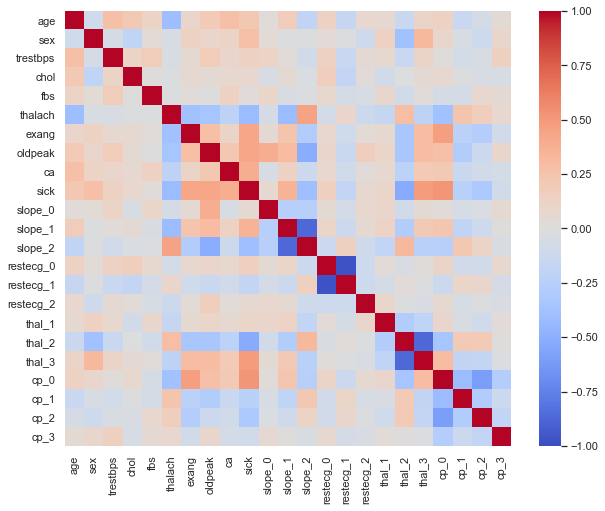

In [114]:
# compute correlations between every pair of variables
cortable = heart.corr(method = 'pearson')

# plot correlations in a heatmap
sns.set(rc = {'figure.figsize':(10, 8)})
sns.heatmap(cortable, vmin = -1, vmax = 1, cmap = 'coolwarm')

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [115]:
# print sorted correlation coefficients with sick column
cortable['sick'].sort_values()

thal_2      -0.527334
thalach     -0.421741
slope_2     -0.394066
cp_2        -0.316742
cp_1        -0.245879
restecg_1   -0.175322
cp_3        -0.086957
fbs          0.028046
slope_0      0.063554
restecg_2    0.068410
chol         0.085239
thal_1       0.106589
trestbps     0.144931
restecg_0    0.159775
age          0.225439
sex          0.280937
slope_1      0.362053
ca           0.391724
oldpeak      0.430696
exang        0.436757
thal_3       0.486112
cp_0         0.516015
sick         1.000000
Name: sick, dtype: float64

[Discuss correlations here] E.g., We find the the strongest direct correlation between the presence of exercise induced angina (also a binary), and depression induced by exercise relative to rest indicates a strong direct correlation. Both of these are understandable as heart failure under conditions of duress is a clear indication of heart disease. Conversely, maximum heart rate achieved is inversely correlated, likely as a healthy heart is unable to achieve a high heart rate.

The 3 strongest _positive_ correlations with 'sick' are: 
* No chest pain
* Reversible defect found in thallium stress test
* Exercise-induced angina 

    I learned that the thallium stress test uses radiolabeled thallium isotopes to image blood flow through the heart, so a problem detected in that test would be backed up by a physician's judgement. Exercise-induced angina means that the patient experiences angina (not enough blood flow to the heart, resulting in bad chest/neck/shoulder pain) when they start exercising. Both of these seem to be indicators that the patient has a heart condition, meaning the `thal_3` and `exang` correlations make sense to me here. However, it's counterintuitive to me that `cp_0` is so positively correlated... I'd expect no chest pain to indicate no heart disease. Maybe people aren't self-reporting their chest pain accurately/honestly?

The 3 strongest _negative_ correlations with 'sick' are:
* "Fixed" defect found in thallium stress test
* Maximum heart rate achieved
* Upsloping exercise ST segment

    Here, it makes intuitive sense that a healthy heart would be able to achieve a higher max heart rate than a sick heart, so I understand why max heart rate would be negatively correlated with being sick. However, it's odd that these other two features show up as negatively correlated... I learned that an upsloping ST segment can indicate the presence of a blocked left anterior descending artery (AKA the cause of the "widowmaker" heart attack), so I would expect that to be strongly _positively_ correlated with heart disease. Similarly, I'd expect the presence of a defect in the thallium stress test to indicate heart disease, not against heart disease. This could have to do with interpretation of the word "fixed", maybe it means "repaired" rather than "irreversible"? Online sources seemed to indicate either could be the case.

In [116]:
# check proportion of sick people in each chest pain group from the raw data... this does line up with the weird correlation
heart0[['cp', 'sick']].groupby('cp').mean()

,sick
cp,
0,0.727273
1,0.180000
2,0.206897
3,0.304348


In [117]:
# same with slope:
heart0[['slope', 'sick']].groupby('slope').mean()

,sick
slope,
0,0.571429
1,0.650000
2,0.246479


In [118]:
# also same with thal (ignore row 0):
heart0[['thal', 'sick']].groupby('thal').mean()

,sick
thal,
0,0.500000
1,0.666667
2,0.216867
3,0.760684


## Part 2. Prepare the Data

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

We're going to ask you to prepare 2 batches of data:
1. Raw numeric data that hasn't gone through any additional pre-processing.
2. Data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

In [119]:
# function to report on how well a model did
def modelPerformance(lab, pred):
    print("Accuracy: " + str(metrics.accuracy_score(lab, pred)))
    print("Precision: " + str(metrics.precision_score(lab, pred)))
    print("Recall: " + str(metrics.recall_score(lab, pred)))
    print("F1 score: " + str(metrics.f1_score(lab, pred)))

### Question 2.1
Save the target column as a separate array and then drop it from the dataframe. 

In [120]:
# save response variable from original data
heart0_y = list(map(int, heart0['sick']))

# get all predictor variables from original data
heart0_x = heart0.drop('sick', axis = 1)
heart0_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
dtypes: float64(1), int64(12)
memory usage: 30.9 KB


### Question 2.2
Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 85% of your total dataframe (hint: use the `train_test_split` method). Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [121]:
train_raw, test_raw, train_raw_lab, test_raw_lab = train_test_split(heart0_x, heart0_y, train_size = 0.85, random_state = 22)

print(train_raw.shape)
print(len(train_raw_lab))
print(test_raw.shape)
print(len(test_raw_lab))

(257, 13)
257
(46, 13)
46


Looks like the split was successful. 

### Question 2.3
In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN rlies on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a KNN algorithm on our data (use `scikit-learn`) and report the results. For this initial implementation simply use the default settings. Report on the accuracy of the resulting model.

In [122]:
# initialize a KNN model
knc_raw = KNeighborsClassifier()

# fit this model to the training data
trainfit_raw = knc_raw.fit(train_raw, train_raw_lab)

# use the fit to predict the test labels
testpred_raw = knc_raw.predict(test_raw)

# evaluate accuracy of the model
modelPerformance(testpred_raw, test_raw_lab)

Accuracy: 0.5869565217391305
Precision: 0.43478260869565216
Recall: 0.625
F1 score: 0.5128205128205128


### Question 2.4 
Now implement a pipeline of your choice to transform the data. You can opt to handle null values and categoricals however you wish, however please scale your numeric features using standard scaler. Refer to Project 1 for a example pipeline that you can mimic.

In [123]:
# heart0 is the raw data from pd.read_csv

# remove samples with thal == 0
print(heart0.shape)
heart_clean = heart0.loc[heart0['thal'] > 0,:]
print(heart_clean.shape)

# define numerical/categorical variables
num = ['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca']
cat = list(set(heart_clean.columns) - set(num) - set(['sick']))
print(num)
print(cat)

# remove 'sick' and recode to int
# save response variable from original data
heart_clean_y = list(map(int, heart_clean['sick']))

# get all predictor variables from original data
heart_clean_x = heart_clean.drop('sick', axis = 1)

heart_clean_x.info()

(303, 14)
(301, 14)
['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'ca']
['slope', 'restecg', 'thal', 'cp']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 13 columns):
age         301 non-null int64
sex         301 non-null int64
cp          301 non-null int64
trestbps    301 non-null int64
chol        301 non-null int64
fbs         301 non-null int64
restecg     301 non-null int64
thalach     301 non-null int64
exang       301 non-null int64
oldpeak     301 non-null float64
slope       301 non-null int64
ca          301 non-null int64
thal        301 non-null int64
dtypes: float64(1), int64(12)
memory usage: 32.9 KB


In [124]:
# define full pipeline
full_pipe = ColumnTransformer([ 
    ('num', StandardScaler(), num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat)
])

### Question 2.5
Now split your pipelined data into an 85/15 split and run the same KNN as you did previously. Report its accuracy, and discuss the implications of the different results you are obtaining.

In [125]:
# split into train/test subsets
train, test, train_lab, test_lab = train_test_split(heart_clean_x, heart_clean_y, train_size = 0.85, random_state = 22)

print(train.shape)
print(len(train_lab))
print(test.shape)
print(len(test_lab))

(255, 13)
255
(46, 13)
46


In [126]:
# run train and test data through the pipeline
train_pipe = full_pipe.fit_transform(train)
test_pipe = full_pipe.transform(test)

print(train_pipe.shape)
print(test_pipe.shape)

(255, 22)
(46, 22)


In [127]:
# get a new kNN model
knc = KNeighborsClassifier()

# fit to training data
trainfit = knc.fit(train_pipe, train_lab)

# predict test labels
testpred = knc.predict(test_pipe)

# output accuracy
modelPerformance(testpred, test_lab)

Accuracy: 0.7391304347826086
Precision: 0.7391304347826086
Recall: 0.7391304347826086
F1 score: 0.7391304347826085


Using the pipelined data as opposed to the raw data, I saw a large increase in all four "goodness" metrics that I used. I would attribute this improvement in the model's performance to (1) scaling the numerical data, meaning factors with large values didn't arbitrarily drive the model, and (2) one-hot encoding the categorical variables which didn't make sense as sequential progressions of severity, meaning we could more easily assume that each feature contributed either positively or negatively to the response variable. 

### Question 2.6 Hyperparameter Optimization
As we saw in lecture, the KNN Algorithm includes an `n_neighbors` attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now letting `n` take on the values 1, 2, 3, 5, 7, 9, 10, 20, 50, 75, and 100. Run your model for each value and report the accuracy for each. Then, create a plot of accuracy versus `n_neighbors` and discuss how and why the accuracy changes as `n_neighbors` changes.

HINT: leverage Python's ability to loop to run through the array and generate results so that you don't need to manually code each iteration.

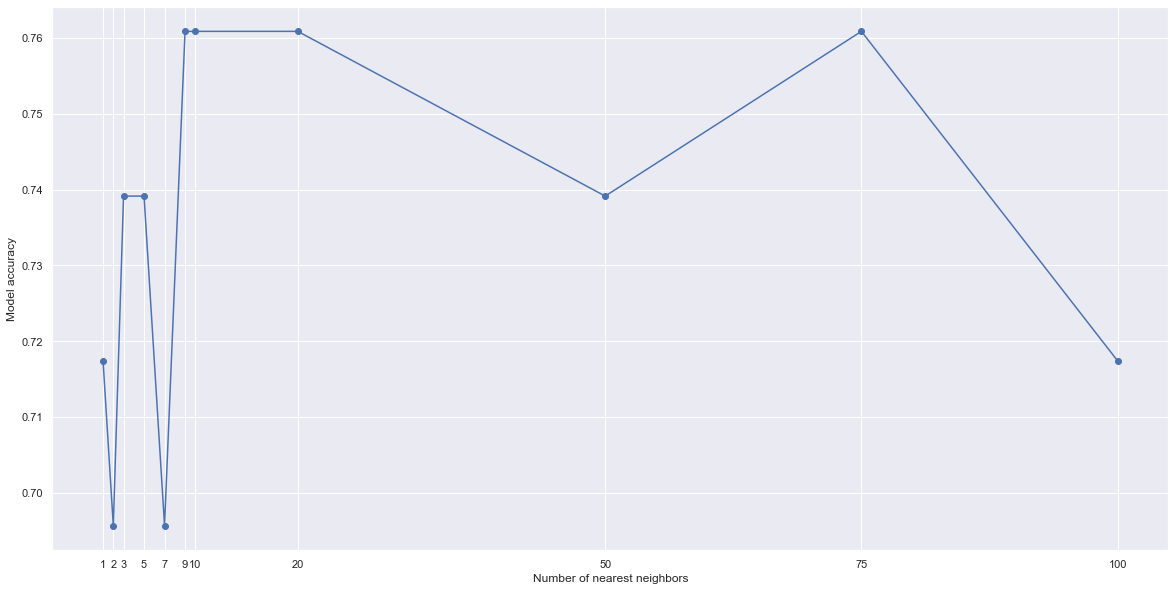

In [128]:
# define hyperparams we want to test
nvec = [1, 2, 3, 5, 7, 9, 10, 20, 50, 75, 100]

def getModelAcc(train_x, train_y, test_x, test_y, thisN):
    '''Return accuracy of a kNN model with train/test data and thisN nearest neighbors'''
    # make a kNN model with the n from this iteration
    knc_n = KNeighborsClassifier(n_neighbors=thisN)
    # fit to training data
    knc_n.fit(train_x, train_y)
    # predict test labels
    test_pred = knc_n.predict(test_x)
    # report accuracy
    return metrics.accuracy_score(test_y, test_pred)

# compute accuracy of each model
accvec = [getModelAcc(train_pipe, train_lab, test_pipe, test_lab, i) for i in nvec]

# plot results
from matplotlib.pyplot import figure

figure(figsize = (20, 10))
plt.plot(nvec, accvec, '-o')
plt.xlabel("Number of nearest neighbors")
plt.xticks(nvec)
plt.ylabel("Model accuracy")
plt.show()

## Part 3. Additional Learning Methods
So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare results. Throughout this part, use the data that was produced by your pipeline earlier.

### Linear Decision Boundary Methods
We'll spend some time exploring logistic regression and SVM methods.

### Question 3.1 Logistic Regression
Let's now try a classifier, we introduced in lecture, one that's well known for handling linear models: logistic regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.  Implement a logistic regression classifier on your data with the default settings. Report accuracy, precision, recall, and F1 score and plot a confusion matrix.

In [129]:
# get a logistic regression object
logreg = LogisticRegression()

# fit to the training data
logreg.fit(train_pipe, train_lab)

# predict test labels
test_pred = logreg.predict(test_pipe)

# output metrics
modelPerformance(test_lab, test_pred)

Accuracy: 0.7391304347826086
Precision: 0.72
Recall: 0.782608695652174
F1 score: 0.7499999999999999


/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


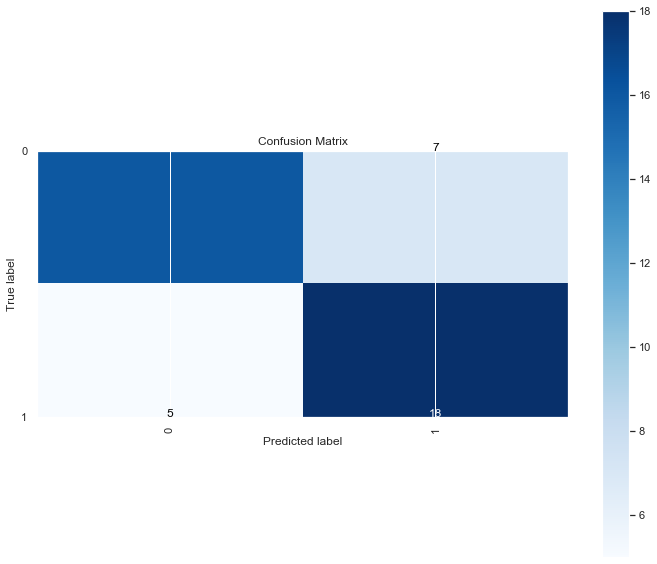

In [130]:
# plot confusion matrix
draw_confusion_matrix(test_lab, test_pred, [0, 1])
# draw_confusion_matrix([1, 1, 1, 0, 0, 0], [1, 1, 1, 0, 0, 1], [0, 1])

### Question 3.2
Discuss what each measure (accuracy, precision, recall, and F1 score) is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.


TP = True positive

FP = False positive

TN = True negative

FN = False negative

* __Accuracy__ [(TP+TN)/(TP+TN+FP+FN)] is the proportion of total decisions (categorizing a person as either sick or not sick) that were correct. This is important because it includes how well the model selected positives and negatives. It's different from other metrics because it has no preference for avoiding FP or FN. Accuracy is a useful metric when we already know the data is well balanced and we care equally about avoiding FP and FN. For example, accuracy would be a fine metric to use on a model that predicts whether someone is male or female. We know a random sample of the population would be balanced, and it's hard to say if FP or FN would matter more in this case. 


* __Precision__ [TP/(TP+FP)] is the proportion of "positive" calls (categorizing a person as sick) that were correct. This is important because it tells us specifically how much we can trust the positive calls that the model makes, which is also what sets it apart from other metrics (it focuses on FP only, not FN). Precision is a useful metric on a model where we care more about avoiding FP than avoiding FN. For example, I'd use precision to evaluate a model that was predicting whether someone committed a crime or not. In my opinion it's better to let someone who did a crime go than to incarcerate an innocent person.


* __Recall__ [TP/(TP+FN)] is the proportion of truly sick people that were correctly called sick by the model. This is important because it tells us how likely it is that there are sick people in the sample that the model missed, which also sets it apart (it focuses on FN only, not FP). Recall is a useful metric for a model where we care more about avoiding FN than FP. For example, I'd use recall to evaluate a model that was predicting whether or not someone had a disease. I think it's better to be on the safe side and have to tell a handful of people that they're actually _not_ sick regardless of what the model said, rather than tell some sick people that they're healthy and allow their condition to get worse undiagnosed.


* __F1 score__ [(2*Recall*Precision)/(Recall+Precision)] is a weighted average of recall and precision. It's important because, like accuracy, it gives an overall measure of how well the model classifies positives and negatives, but, unlike accuracy, it factors in how balanced the dataset is. For example, in a situation where the model had TP = 97, and FP = FN = TN = 1, accuracy would be 97% while F1 would be 50%. It's more informative to use F1 in this unbalanced dataset because it reflects how the vast majority of the accuracy of the model comes from TP, and there is almost no evidence that the model handles negatives well. This would be useful in something like predicting whether a person is right or left handed, where we know there is an imbalance in the population and we don't have a preference for avoiding FP or FN.

### Question 3.3
Graph the ROC curve of the logistic regression model.

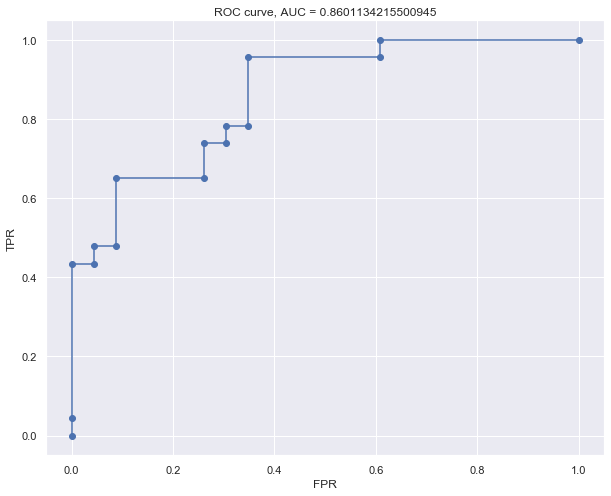

In [131]:
# function to draw ROC curve

def draw_roc_curve(model, x, y):
    # get probabilities of each positive prediction from logistic model
    test_pred_prob = model.predict_proba(x)[:,1]

    # compute ROC curve
    fpr, tpr, thresh = metrics.roc_curve(y, test_pred_prob, pos_label = 1)

    # compute AUC
    auc = metrics.auc(fpr, tpr)

    # plot ROC curve
    plt.plot(fpr, tpr, '-o')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC curve, AUC = " + str(auc))
    plt.show()

draw_roc_curve(logreg, test_pipe, test_lab)

### Question 3.4
Describe what an ROC curve is and what your ROC graph output is showing.

An ROC curve is a plot of the false positive rate (FP/(FP+TN)) against the true positive rate (AKA recall), evaluated at different probability thresholds for how confident the model needs to be of a positive call before it makes that positive call. From left to right, the probability decreases from most stringent to least stringent. In the bottom left corner, the model must be absolutely sure of a positive call before making it, so false positives are avoided completely, but true positives are also avoided since the model will never be so confident. In the top right, every sample is called a positive, so every existing positive is detected, but every existing negative is also called a positive. In between these points, the model's ability to differentiate between positives and negatives is visualized. Ideally, the curve stays up and to the left, meaning that as more and more positives are called, they tend to be TP more than they tend to be FP. The "goodness" of a model can be quantified by taking the area under this curve (AUC == 1 means the model performs ideally, AUC == 0.5 means the model can't really predict anything). 

### Question 3.5
Let's tweak a few settings. Set your solver to `newton-cg`, your `max_iter=4`, and `penalty='none'`, and rerun your model. Report out the same metrics (the 4 + confusion matrix) as before. How do your results change?

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Accuracy: 0.717391304347826
Precision: 0.7083333333333334
Recall: 0.7391304347826086
F1 score: 0.723404255319149


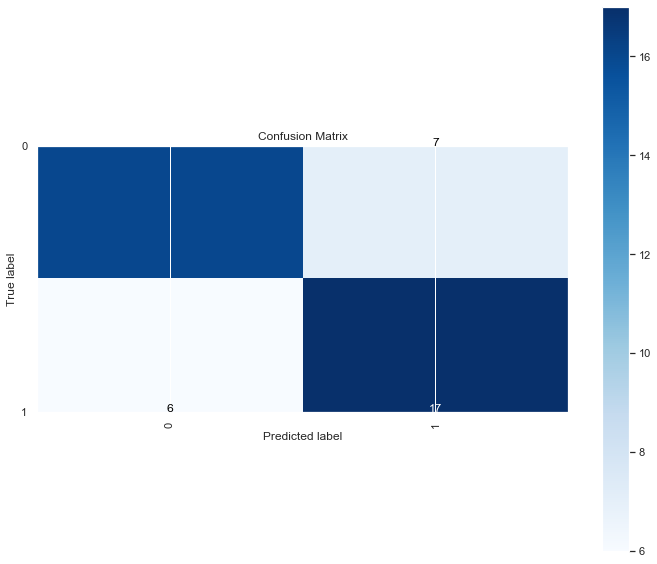

In [132]:
# run the logistic regression again with tweaks
logregplus = LogisticRegression(solver='newton-cg', max_iter=4, penalty='none')

logregplus.fit(train_pipe, train_lab)
test_pred_plus = logregplus.predict(test_pipe)
modelPerformance(test_lab, test_pred_plus)

draw_confusion_matrix(test_lab, test_pred_plus, [0,1])

### Question 3.6
Did you notice that when you ran the previous model you got the following warning: `ConvergenceWarning: The max_iter was reached which means the coef_ did not converge.` Check the documentation and see if you can implement a fix for this problem, and again report your results.

Note: if you did not get a warning, which might happen to those running this notebook in VSCode, please try running the following code, as described [here](https://github.com/microsoft/vscode-jupyter/issues/1312):
```
import warnings
warnings.simplefilter(action="default")
```

Accuracy: 0.717391304347826
Precision: 0.7272727272727273
Recall: 0.6956521739130435
F1 score: 0.711111111111111


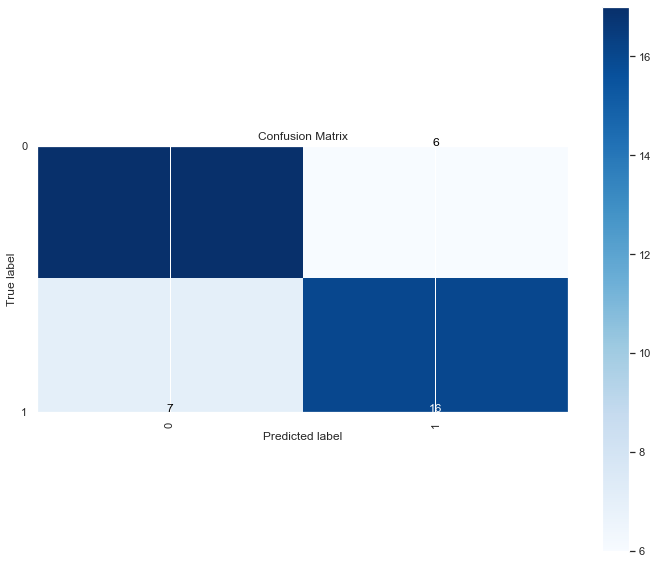

In [133]:
# try to avoid the warning
logregplus2 = LogisticRegression(solver='newton-cg', max_iter=1000, penalty='none')

logregplus2.fit(train_pipe, train_lab)
test_pred_plus2 = logregplus2.predict(test_pipe)
modelPerformance(test_lab, test_pred_plus2)

draw_confusion_matrix(test_lab, test_pred_plus2, ['0', '1'])


### Question 3.7
Explain what you changed and why this fixed the `ConvergenceWarning` problem. Are there any downsides of your fix? How might you have harmed the outcome instead? What other parameters you set may be playing a factor in affecting the results?

I increased the max number of iterations for the model to 1000 from 4. This got rid of the warning because the solver was able to converge on a solution before reaching the 1000th iteration (it must have happened between iteration 4 and 1000). However, my F1 score actually went down from the 4-iteration model. I think this is because we are setting penalty='none', which means the model is not regularized. Thus, by allowing the model to run more iterations, it might be overfitting to the training data, which would explain why it doesn't perform as well on the test data. With only 4 iterations, the model probably can't get complex enough to be overfit to the training data.

### Question 3.8
Rerun your logistic classifier, but modify the `penalty='l1'`, `solver='liblinear'` and again report the results.


/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.7391304347826086
Precision: 0.7391304347826086
Recall: 0.7391304347826086
F1 score: 0.7391304347826085


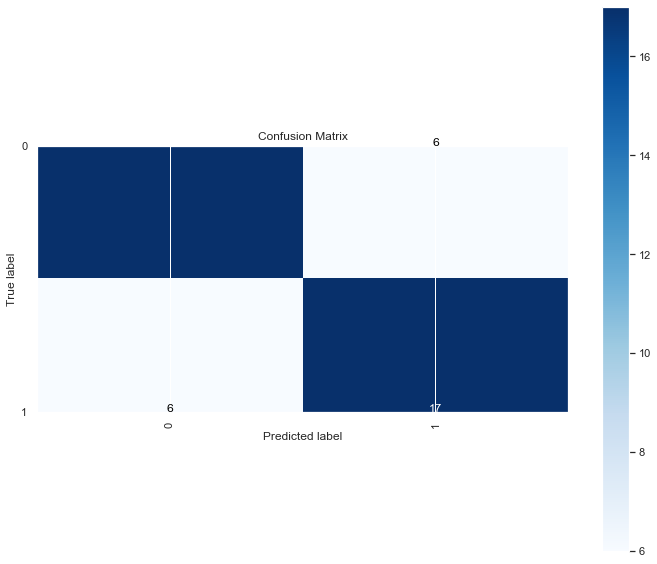

In [134]:
logreg_l1 = LogisticRegression(solver='liblinear', max_iter = 4, penalty='l1')

logreg_l1.fit(train_pipe, train_lab)
test_pred_l1 = logreg_l1.predict(test_pipe)
modelPerformance(test_lab, test_pred_l1)

draw_confusion_matrix(test_lab, test_pred_l1, ['0', '1'])

### Question 3.9
Explain what what the two solver approaches are, and why the model with `liblinear` and `l1` penalty likely produced the optimal outcome.

In order for the logistic model to 'learn' its parameters so it can classify new data, a likelihood function of multiple variables, intercept and slope, must be maximized (equivalent to minimizing a loss function). 

`newton-cg` uses Newton's method to solve for the optimal parameters, while `liblinear` uses gradient descent. The main difference between these is the way that they determine which direction to go towards the local/global minimum in the multi-dimensional parameter space. Newton's method uses the second partial derivatives of the parameter space (the Hessian matrix), while gradient descent uses the first partial derivatives of the parameter space (the gradient). Both of them decide which direction to travel based on their approximation of the derivative, take a step in that direction, and then update their approximation based on the udpated position.

In this case, `liblinear` with the `l1` penalty did do best by the metrics we considered, probably because its main drawback (being stuck in a local minimum which is not the global minimum) was not possible due to the logistic regression being convex. `newton-cg` did almost as well, but because it considers the second derivative of the parameter space, it is more attracted to saddle points than gradient descent is. While the logistic regression loss function is convex, it might include saddle points. It's possible that Newton's method was stuck in a saddle point in this problem and missed the true global minimum of the parameter space. 

### Question 3.10
We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and the difference between L1 and L2 penalties.

A penalty term is an extra term added to the loss function intended to control how complex the model becomes (this is called regularization). Non-regularized models are prone to overfitting, because they might learn a very complex set of parameters that fits the training data perfectly but doesn't generalize. It's usually better to keep the model as simple as possible to capture the underlying distribution of the data. 

To quantify the complexity of the model, different types of penalties are added to the loss function. An L1 penalty term includes the absolute value of each parameter. In logistic regression, this is:

$$\lambda\sum_{j=1}^m|\Beta_j|$$

An L2 penalty term includes the square of each parameter, which shows up in logistic regression as:

$$\lambda\sum_{j=1}^m\Beta_j^2$$

Where $m$ is the number of parameters in the model.

Because the loss function is minimized as part of the solution to the regression, by adding a term that represents model complexity to the loss function we also minimize the complexity of the model.

In action, L2 regularization (also called ridge regression) stops the size of each parameter from becoming ridiculous but generally doesn't erase features altogether. L1 regularization (also called LASSO) often ends up reducing betas down to 0, so it's often chosen when someone is trying to figure out which variables are the best predictors to keep in their model. 

### Question 3.11 Support Vector Machine (SVM)

A support vector machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In 2-D space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

Implement an SVM classifier on your pipelined data (recommend using `scikit-learn`) For this implementation you can simply use the default settings, but set `probability=True`.

In [135]:
from sklearn.svm import SVC

# generate an SVM object
svmclassifier = SVC(probability=True)

# fit the SVM model to training data
svmclassifier.fit(train_pipe, train_lab)

# predict test labels with SVM
test_pred_svm = svmclassifier.predict(test_pipe)

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Question 3.12 
Report the accuracy, precision, recall, F1 Score, and confusion matrix of the resulting model.

Accuracy: 0.717391304347826
Precision: 0.7083333333333334
Recall: 0.7391304347826086
F1 score: 0.723404255319149


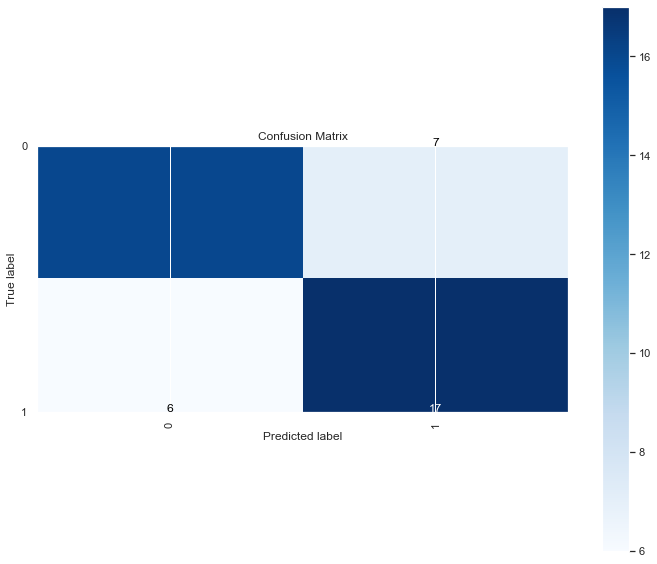

In [136]:
# evaluate how the model did
modelPerformance(test_lab, test_pred_svm)

# generate confusion matrix
draw_confusion_matrix(test_lab, test_pred_svm, ['0', '1'])

### Question 3.13
Rerun your SVM, but now modify your model parameter kernel to be `linear`. Again report your accuracy, precision, recall, F1 scores, and confusion matrix and plot the new ROC curve.  

In [137]:
svmclassifier2 = SVC(probability=True, kernel='linear')

svmclassifier2.fit(train_pipe, train_lab)

test_pred_svm2 = svmclassifier2.predict(test_pipe)

modelPerformance(test_lab, test_pred_svm2)

Accuracy: 0.717391304347826
Precision: 0.7272727272727273
Recall: 0.6956521739130435
F1 score: 0.711111111111111


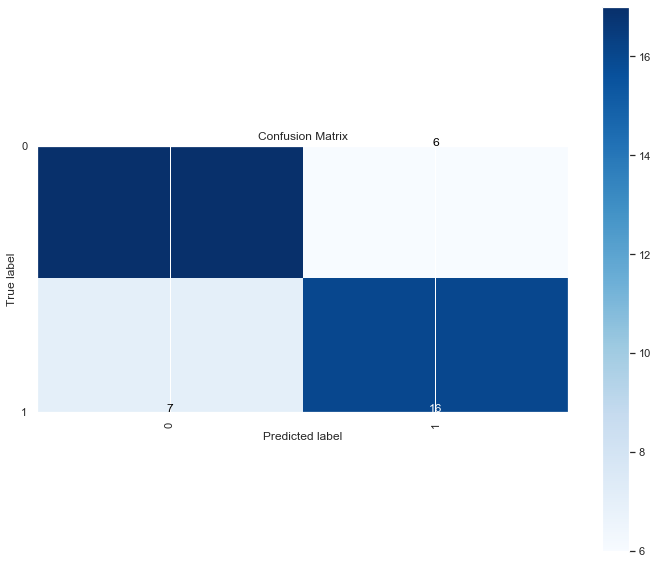

In [138]:
draw_confusion_matrix(test_lab, test_pred_svm2, ['0', '1'])

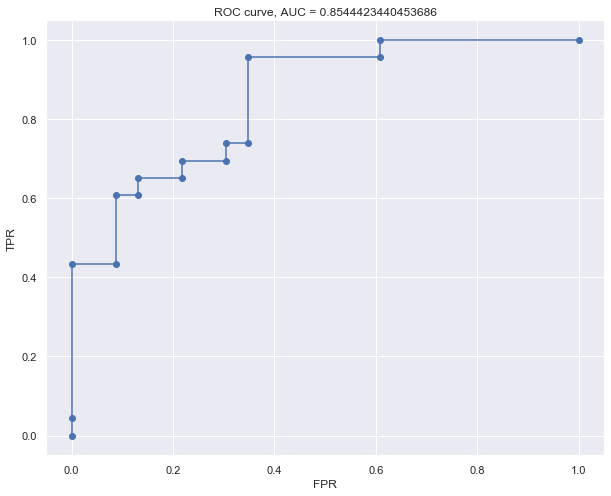

In [139]:
draw_roc_curve(svmclassifier2, test_pipe, test_lab)

### Question 3.14
Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

I found that while the `'linear'` and `'rbf'` kernels had similar accuracy, `'linear'` had better precision, and `'rbf'` had better recall. 

I learned that an SVM kernel works by generating a new augmented feature perpendicular to all other features in the feature space, and uses this new feature to generate a hyperplane that ideally separates most of the data into its correct class. The difference between the two kernels is that the `'linear'` kernel uses a *linear* function to draw this hyperplane, while the `'rbf'` kernel uses a *non-linear* function called the Radial Basis Function (RBF).

Each of these has pros and cons—the linear model is simpler, meaning it's less prone to overfitting and requires less computational power. The RBF model is more complex, so it has the ability to capture nonlinear trends in the data that the linear model might miss, but is also vulnerable to learning too much of the training data's underlying structure and failing to generalize (overfitting). 

In my results, I'm seeing that the linear model was better at making reliable predictions (precision), while the RBF model was better at finding all the true positives in the data (recall). This makes sense given their definitions—because the linear model is simpler, it stays on the safe side and is less likely to call a false positive. On the other hand, the RBF model is more complex, allowing it to capture some positives that don't follow the most general trend of the other positives.

### Question 3.15
Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. How do they differ in how they try to find this boundary?


Logistic regression optimizes a likelihood/loss function based on all of the training data, and uses the result of this optimization to find a probability that each data point belongs to each class in the classification problem. Based on the researcher's decision of a threshold for mapping these probabilities to assignments of data points to classes, a hyperplane can be drawn in the feature space that separates data points into their respective classes. 

SVM does not work with a likelihood function, instead optimizing the final separating hyperplane directly. It uses a subset of the data (called the support vectors) which is closest to the class boundaries, and algorithmically generates a hyperplane that distinguises these data from each other with a maximum functional margin.

### Question 3.16
We also learned about linear regression in class. Why is linear regression not a suitable model for this classification task?

A linear model could be fit to the data in a classification problem, but it would not be the right tool to use for a few reasons:

* The output of a linear model is not restricted to [0, 1] and thus can't be interpreted as a probability. Given a max heart rate of 110 bpm, for example, a linear model might predict that the patient's heart disease status is 1.10. What does that mean, when we've encoded sick as 1 and healthy as 0? There's no good way to interpret this prediction and use it to classify the data.
*  Because of this probability issue, there's also no good way to decide which category to put someone in when their predicted status falls in the space between two categories. Where do we put someone who's predicted status is 0.6, or 0.35? We can't assume that being sick is exactly one unit "greater" than being healthy, or that there is a linear relationship between being sick and healthy. What if the predictive feature can climb to 90% of its maximum before an individual's class should change? A linear model wouldn't do a good job of making that distinction. 

Using a logistic regression solves these issues, because its output can be interpreted as a probability, and the probability threshold can be tuned based on the problem in question. 

### Statistical Classification Methods
Now we'll explore a statistical classification method, the naive Bayes classifier.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable. Bayes' theorem states the following relationship, given class variable $C_k$ and dependent feature vector $\bold{x} = [x_1, x_2, ..., x_n]^T$, $$P(C_k | \bold{x}) = \frac{P(C_k)P(\bold{x} | C_k)}{P(\bold{x})}$$

Note for our purposes, there are 2 possible classes (sick or not sick), so $k$ ranges from 1 to 2.

### Question 3.17
Implement a naive Bayes Classifier on the pipelined data. Use the `GaussianNB` model. For this model, simply use the default parameters. Report out the number of mislabeled points that result (i.e., both the false positives and false negatives), along with the accuracy, precision, recall, F1 Score and confusion matrix. Also, plot an ROC curve.

In [140]:
from sklearn.naive_bayes import GaussianNB 

gnb = GaussianNB()

gnb.fit(train_pipe, train_lab)

test_pred_gnb = gnb.predict(test_pipe)

conf_gnb = metrics.confusion_matrix(test_lab, test_pred_gnb)

print("False positives: " + str(conf_gnb[0, 1]))
print("False negatives: " + str(conf_gnb[1, 0]))

modelPerformance(test_lab, test_pred_gnb)

False positives: 5
False negatives: 7
Accuracy: 0.7391304347826086
Precision: 0.7619047619047619
Recall: 0.6956521739130435
F1 score: 0.7272727272727272


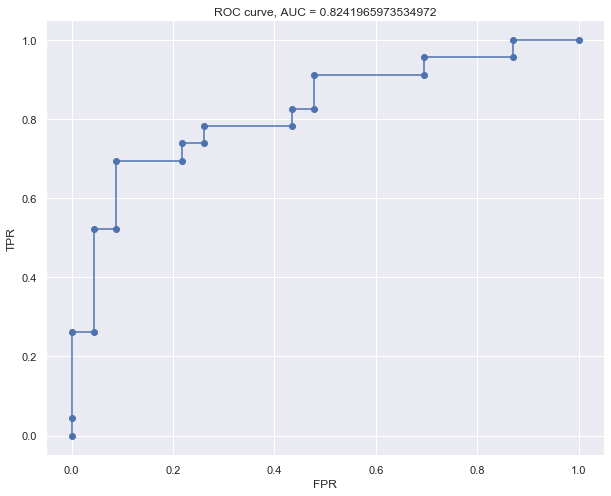

In [141]:
draw_roc_curve(gnb, test_pipe, test_lab)

### Question 3.18
Discuss the observed results. What assumptions about our data are we making here and why might those be inaccurate?

Actually, this model seems to have done the best out of all the models I've tried so far, especially in the precision category. However, it suffers on recall. I'm sure the two biggest pitfalls for this model on my data are that it assumes a Gaussain prior distribution for each of the features, and assumes the features are independent. I know from my histograms at the beginning of this notebook that not all of the features are normally distributed, and I know from the correlation heatmap that many of the features are correlated with each other. So, it's possible that the model's bad performance on recall can be attributed to the model's assumptions being violated for features that would have helped it call more of the actual positive cases as positives. 

## Part 4: Cross Validation and Model Selection
You've sampled a number of different classification techniques, leveraging nearest neighbors, linear classifiers, and statistical classifiers. You've also tweaked with a few parameters for those models to optimize performance. Based on these experiments you should have settled on a particular model that performs most optimally on this dataset. Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the train-test split. To check this, we will conduct a K-fold cross validation of our top 2 performing models, assess their cumulative performance across folds (report accuracy, precision, recall, and F1 score), and determine the best model for our particular data.

### Question 4.1
Select your top 2 performing models and run a 10-Fold cross validation on both. Report your best performing model.


In [142]:
# get a table of model performance across all models we've tried
names = ['kNN_raw', 'kNN_pipe', 'logistic_default', 'logistic_newton_4', 'logistic_newton_1000', 'logistic_liblinear_l1', 'svm_rbf', 'svm_linear', 'gaussianNB']
predictions = [testpred_raw, testpred, test_pred, test_pred_plus, test_pred_plus2, test_pred_l1, test_pred_svm, test_pred_svm2, test_pred_gnb]
labels = [test_raw_lab] + [test_lab]*(len(names)-1)

perfall = pd.DataFrame({'model': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []})

for i in range(len(names)):
    acc = metrics.accuracy_score(labels[i], predictions[i])
    pre = metrics.precision_score(labels[i], predictions[i])
    rec = metrics.recall_score(labels[i], predictions[i])
    f1 = metrics.f1_score(labels[i], predictions[i])
    perfall.loc[len(perfall.index)] = [names[i], acc, pre, rec, f1]

perfall

,model,accuracy,precision,recall,f1
0,kNN_raw,0.586957,0.625000,0.434783,0.512821
1,kNN_pipe,0.739130,0.739130,0.739130,0.739130
2,logistic_default,0.739130,0.720000,0.782609,0.750000
3,logistic_newton_4,0.717391,0.708333,0.739130,0.723404
4,logistic_newton_1000,0.717391,0.727273,0.695652,0.711111
5,logistic_liblinear_l1,0.739130,0.739130,0.739130,0.739130
6,svm_rbf,0.717391,0.708333,0.739130,0.723404
7,svm_linear,0.717391,0.727273,0.695652,0.711111
8,gaussianNB,0.739130,0.761905,0.695652,0.727273


Based on F1 score, my best two models are the default logistic regression (L2-penalized, lbfgs solver) and L1-penalized logistic regression solved with the liblinear solver. 

In [143]:
from sklearn import model_selection

# set up the data for K-fold cross validation

# define the data splitter that will divide our data
kf = model_selection.KFold(n_splits = 10, random_state = 10000, shuffle = True)

# # make sure it looks good on the raw data
# for train_idx, test_idx in kf.split(heart0):
#     print("Train: ", train_idx, "Test: ", test_idx)

In [144]:
from sklearn.pipeline import make_pipeline

# define full pipelines for the data, including the classfier
logreg_kfold_pipe = make_pipeline(full_pipe, logreg) # logistic default model
logreg_l1_kfold_pipe = make_pipeline(full_pipe, logreg_l1) # logistic liblinear l1 model 

# run cross-validation on logistic_default and logistic_liblinear_l1
logreg_result_kfold = model_selection.cross_val_score(logreg_kfold_pipe, heart_clean_x, heart_clean_y, cv = kf)
logreg_l1_result_kfold = model_selection.cross_val_score(logreg_l1_kfold_pipe, heart_clean_x, heart_clean_y, cv = kf)

print("Mean accuracy for default logistic regression: " + str(logreg_result_kfold.mean()))
print("Mean accuracy for liblinear logistic regression with L1 penalty: " + str(logreg_l1_result_kfold.mean()))

/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be ch

Mean accuracy for default logistic regression: 0.8372043010752688
Mean accuracy for liblinear logistic regression with L1 penalty: 0.8338709677419354


/Users/niko/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Question 4.2
Discuss your results and why they differ slightly from what you got for the 2 models above.

I found that both models had a very similar mean accuracy score, which was higher than the accuracy they both had above. To me this means that the train_test_split I happened to use at the beginning of this notebook ended up being a permutation of the data that was harder for each of the models to do well on than the average split of the data. With 10 different randomized train/test combinations, the model generally did better than it did on the single combination used above. 

### Question 4.3
Out of these 2 models, based on their scores for the 4 metrics, which one would you pick for this specific case of predicting if someone has heart disease or not?

Since we're predicting heart disease, which is a potentially life-threatening condition, I would prioritize avoiding false negatives over avoiding false positives. It's much better to tell someone they may have a disease, send them in for some more scans and clinical tests, and decide later that they're actually healthy, than to accidentally tell a sick person they're predicted to be healthy and let their disease worsen without treatment.

Because of this, my main metric to compare the models on will be recall. I want to focus on finding all the truly sick people who are out there, even if I accidentally predict a few healthy people to be sick. The default logistic model has higher recall than the liblinear version, so I would select the default logistic model.